### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

### Переходим к практике

Три ячейки ниже делаем в Google Colaboratory

- установим razdel
- установим pymorphy2

In [40]:
!pip install razdel

In [41]:
!pip install pymorphy2

Делаем доступ к Googl Drive

In [37]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [36]:
import pandas as pd

Наши новости

In [38]:
news = pd.read_csv("/gdrive/MyDrive/2_ver_actual Артем Зраев. 10.2020/Lection2/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [39]:
users = pd.read_csv("/gdrive/MyDrive/2_ver_actual Артем Зраев. 10.2020/Lection2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [42]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [43]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [44]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [46]:
with open('/gdrive/MyDrive/2_ver_actual Артем Зраев. 10.2020/Lection2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [47]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [48]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 21.1 s, sys: 207 ms, total: 21.3 s
Wall time: 21.4 s


In [49]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 7s, sys: 221 ms, total: 4min 7s
Wall time: 4min 9s


А теперь в 3 строчки обучим нашу модель

In [50]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [51]:
common_dictionary[5]

'банк'

In [52]:
common_corpus[0][0]

(0, 5)

In [97]:
len(texts[0])

118

Все просто - это словарь наших слов

Запускаем обучение

In [56]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 53.3 s, sys: 25.2 s, total: 1min 18s
Wall time: 50.1 s


In [57]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [58]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(6, 0.41308138), (20, 0.56447965)]

In [59]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: самолёт спутник рынок российский двигатель тыс поставка
topic_1: новый эксперт учёный житель древний ран современный
topic_2: животное товар торговый участок площадь церковь теория
topic_3: украина ребёнок банк украинский киев миссия медведев
topic_4: ракета космический роскосмос полёт проверка орбита пуск
topic_5: риск спрос препарат журнал первый падение всё
topic_6: фильм друг рассказывать рекомендовать хороший всё тело
topic_7: сша газ нефть территория корабль турция сторона
topic_8: nn центр клетка данные сотрудник тело помощь
topic_9: учёный исследование научный пациент заболевание операция опубликовать
topic_10: луна пострадать восток космический авиакомпания космос самолёт
topic_11: район военный армия около население км день
topic_12: россия млрд российский правительство глава развитие министр
topic_13: nn турист километр писать мкс марс экипаж
topic_14: исследователь фонд университет экономика учёный банк рынок
topic_15: смерть первый высота птица жизнь nn умереть
to

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [103]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'nn',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [102]:
lda[common_dictionary.doc2bow(news['title'].iloc[5])]

[(1, 0.07139823),
 (6, 0.62691545),
 (16, 0.027950797),
 (20, 0.05359001),
 (24, 0.20658624)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [60]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [61]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.0,0.0,0.0,0.000000,0.106680,0.0,0.511081,0.000000,0.0,0.0,0.112442,0.0,0.000000,0.00000,0.017598,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.245476,0.0
1,4896,0.0,0.000000,0.0,0.0,0.0,0.000000,0.364336,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.613225,0.0,0.000000,0.0
2,4897,0.0,0.000000,0.0,0.0,0.0,0.000000,0.413086,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.564476,0.000000,0.0,0.000000,0.0
3,4898,0.0,0.000000,0.0,0.0,0.0,0.351173,0.253895,0.0,0.000000,0.246397,0.0,0.0,0.095981,0.0,0.021536,0.02197,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,4899,0.0,0.084816,0.0,0.0,0.0,0.000000,0.141985,0.0,0.000000,0.000000,0.0,0.0,0.201516,0.0,0.000000,0.00000,0.000000,0.0,0.416913,0.0,0.000000,0.000000,0.0,0.133148,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [62]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [63]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [64]:
doc_dict[293622]

array([0.        , 0.        , 0.11092227, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15830591,
       0.        , 0.        , 0.        , 0.0870671 , 0.01781947,
       0.        , 0.        , 0.        , 0.02737058, 0.02537375,
       0.25517008, 0.        , 0.        , 0.22547182, 0.08561729])

In [65]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [66]:
get_user_embedding(user_articles_list)

array([0.02425855, 0.01320494, 0.01295348, 0.00499968, 0.00933887,
       0.00932358, 0.00180213, 0.07161867, 0.02362374, 0.04273773,
       0.01218658, 0.04522388, 0.11806628, 0.        , 0.        ,
       0.        , 0.01276462, 0.01193666, 0.01193606, 0.13696048,
       0.07915528, 0.03478572, 0.        , 0.28038103, 0.03178751])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [67]:
#users['articles'].iloc[33]

In [68]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [69]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.071004,0.143206,0.062536,0.005798,0.063081,0.030408,0.004741,0.068514,0.026384,0.017489,0.023403,0.010223,0.041749,0.002970,0.019598,0.010226,0.015658,0.004562,0.070648,0.096707,0.011979,0.000000,0.152217,0.030950
1,u108690,0.051654,0.022633,0.009316,0.094436,0.000000,0.020369,0.016335,0.021175,0.057363,0.038736,0.013094,0.026190,0.168791,0.002056,0.008103,0.028514,0.034287,0.007316,0.018678,0.118573,0.118557,0.000000,0.008774,0.094439,0.003136
2,u108339,0.021136,0.049473,0.005971,0.000000,0.007849,0.004092,0.004423,0.021133,0.142807,0.058693,0.043921,0.042648,0.084101,0.005915,0.002606,0.012935,0.064205,0.010638,0.027827,0.148175,0.018057,0.017849,0.018747,0.153919,0.011583


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [71]:
target = pd.read_csv("/gdrive/MyDrive/2_ver_actual Артем Зраев. 10.2020/Lection2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [72]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.071004,0.143206,0.062536,0.005798,0.063081,0.030408,0.004741,0.068514,0.026384,0.017489,0.023403,0.010223,0.041749,0.002970,0.019598,0.010226,0.015658,0.004562,0.070648,0.096707,0.011979,0.000000,0.152217,0.030950,0
1,u108690,0.051654,0.022633,0.009316,0.094436,0.000000,0.020369,0.016335,0.021175,0.057363,0.038736,0.013094,0.026190,0.168791,0.002056,0.008103,0.028514,0.034287,0.007316,0.018678,0.118573,0.118557,0.000000,0.008774,0.094439,0.003136,1
2,u108339,0.021136,0.049473,0.005971,0.000000,0.007849,0.004092,0.004423,0.021133,0.142807,0.058693,0.043921,0.042648,0.084101,0.005915,0.002606,0.012935,0.064205,0.010638,0.027827,0.148175,0.018057,0.017849,0.018747,0.153919,0.011583,1


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [74]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [75]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0725746 , 0.02641622, 0.48530597, 0.23837681, 0.23268886,
       0.0429463 , 0.10443433, 0.03553586, 0.05333207, 0.23441749])

In [77]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [78]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.250422, F-Score=0.655, Precision=0.590, Recall=0.735


In [82]:
import itertools

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1630  125]
 [  66  179]]


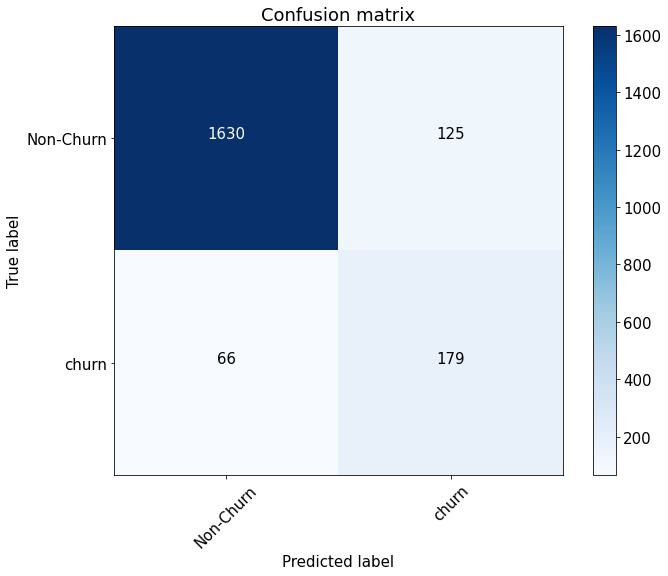

In [84]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [85]:
roc_auc_score(y_test, preds)

0.934956683528112

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk